In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

from scipy.stats import skew
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Sales Forecasting

In [2]:
sales = pd.read_csv("sales_data.csv")

In [3]:
sales

,date,order_value
0,2020-01-01,26101.54
1,2020-01-02,41814.40
2,2020-01-03,42642.98
3,2020-01-04,43074.03
4,2020-01-05,43641.16
...,...,...
1908,2025-03-23,852056.27
1909,2025-03-24,751234.55
1910,2025-03-25,762504.03
1911,2025-03-26,760218.92


In [4]:
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.sort_values('date')
sales = sales.set_index('date')
sales

,order_value
date,
2020-01-01,26101.54
2020-01-02,41814.40
2020-01-03,42642.98
2020-01-04,43074.03
2020-01-05,43641.16
...,...
2025-03-23,852056.27
2025-03-24,751234.55
2025-03-25,762504.03


I loaded the historical *sales data*, converted the date column to the correct datetime format, and set it as the index. These preparatory steps important for transforming the raw data into a properly structured time series ready for analysis and modeling.

## EDA

order_value    0
dtype: int64


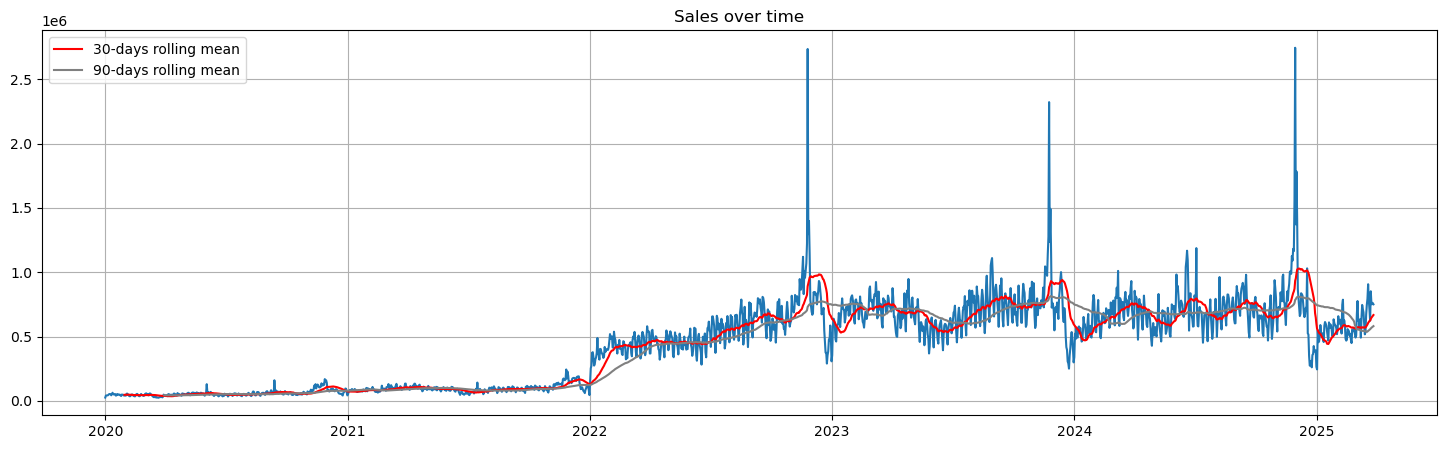

In [5]:
print(sales.asfreq('D').isna().sum())

plt.figure(figsize=(18,5))
plt.plot(sales['order_value'])
plt.title("Sales over time")
plt.plot(sales['order_value'].rolling(30).mean(), label='30-days rolling mean', color='red')
plt.plot(sales['order_value'].rolling(90).mean(), label='90-days rolling mean', color='gray')
plt.legend()
plt.grid(True)
plt.show()

The first __*visualization*__ of the daily sales data shows some important characteristics for forecasting

- __Strong Trend__: There's a clear positive long-term trend in sales, particularly a significant increase beginning around the start of 2022

- __Seasonality__: The data showed yearly spikes (high volatility).

- __Volatility and Noise__: The raw daily sales (order_value) show high day-to-day noise (volatility), which is visually smoothed by the 30-day (red) and 90-day (gray) rolling means.

- __Stationarity__: The increasing trend and clear annual patterns indicate the series is non-stationary, meaning its statistical properties (like the mean) change over time. This suggests that simple models like ARIMA might require differencing, or a more robust model like Prophet or an ETS model capturing the trend and seasonal features should be considered.

Also here we can see that our data has no blank lines.

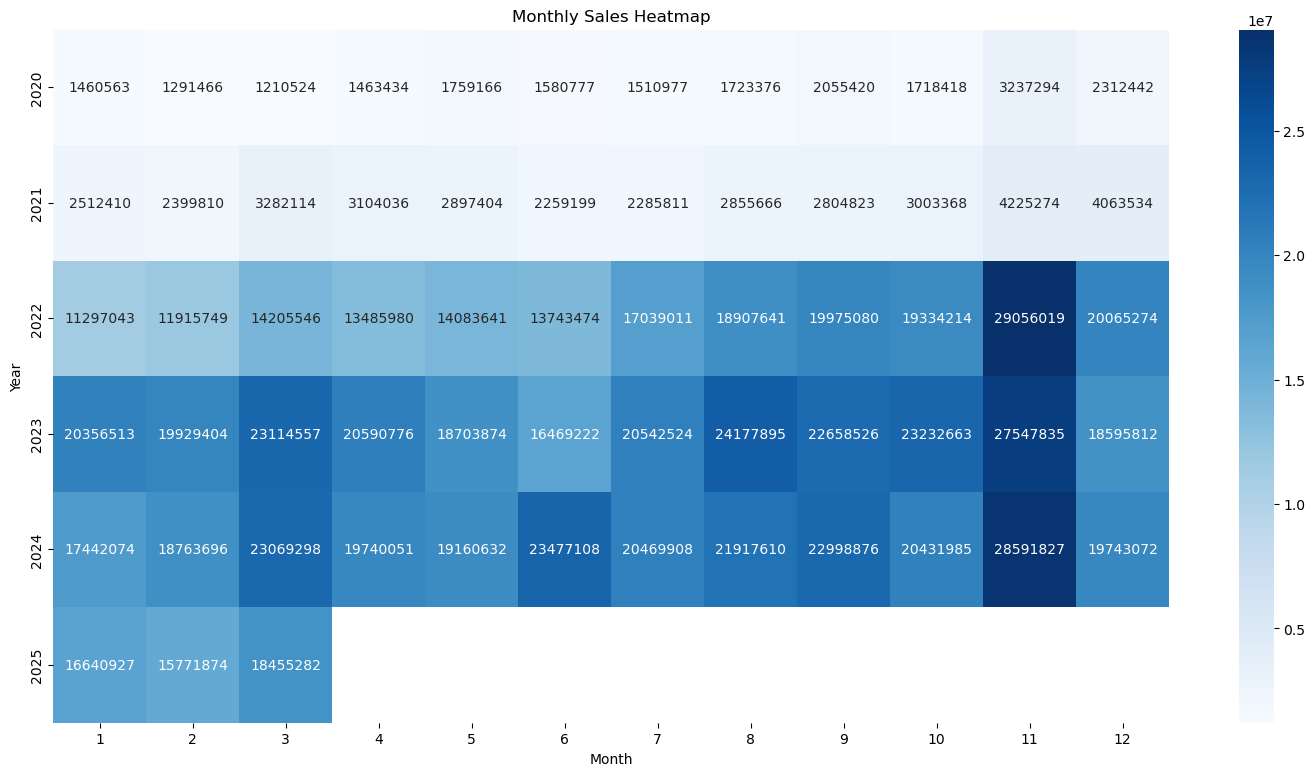

In [6]:
sales['year'] = sales.index.year
sales['month'] = sales.index.month

monthly = sales.groupby(['year','month'])['order_value'].sum().reset_index()

heatmap_data = monthly.pivot(index="year", columns="month", values="order_value")

plt.figure(figsize=(18,9))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues")
plt.title("Monthly Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

This __*heatmap*__ shows the total sales for each month.

Key points:

- __Strong Growth__: The sales got much bigger over time. The blue color is much lighter in 2020/2021 (low sales) and becomes much darker in 2022, 2023, and 2024 (high sales). This confirms the strong growth trend.

- __Clear Yearly Seasonality__: Every year, the sales are highest in the last months of the year, especially November and December. These are the darkest cells in almost every row, showing a clear, strong end-of-year busy season.

- __Lowest Sales Months__: The sales are generally lower in the first few months of the year compared to the rest of the year.

- __Consistency__: The seasonal pattern is repeated every year. This regularity is good because it makes the prediction models - (like Prophet) more accurate.

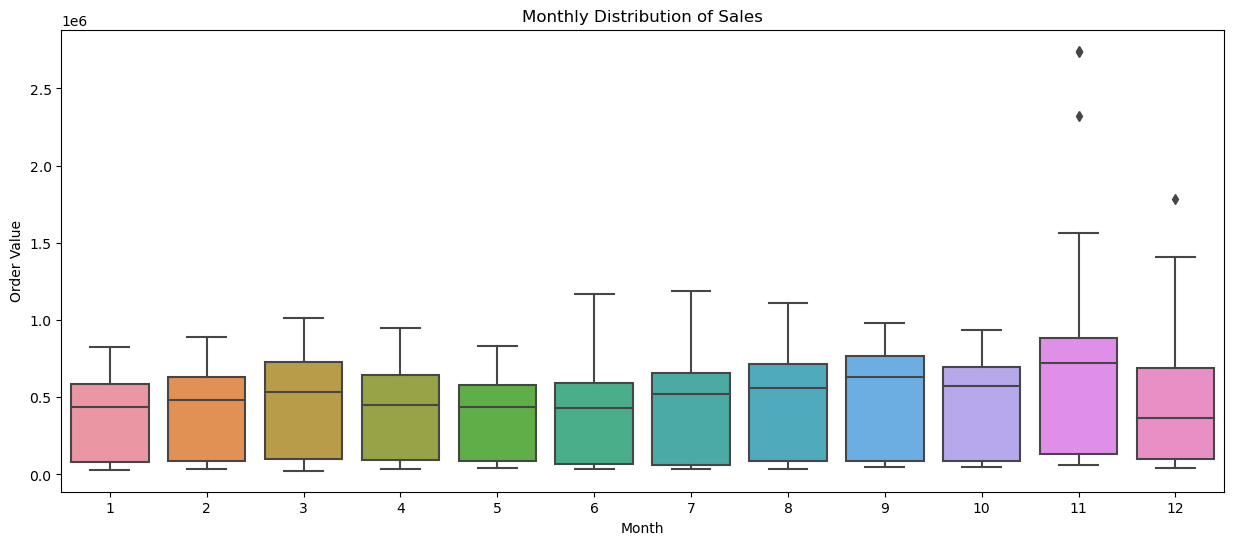

In [7]:
plt.figure(figsize=(15,6))
sns.boxplot(x=sales['month'], y=sales['order_value'])
plt.title("Monthly Distribution of Sales")
plt.xlabel("Month")
plt.ylabel("Order Value")
plt.show()

The __*boxplot*__ gives us a clearer picture of daily sales variation from each month.

Key points:

- __Higher Daily Averages__: Once again, the boxes are higher for months like November and December. This means the typical daily sales are much greater during the end-of-year busy season.

- __More Extreme Sales__: November has the highest box and the longest top *whisker*, and many *outliers*. This means sales in November are not only high on average but also have the biggest difference between the lowest and highest daily sales.

- __Stable Months__: Sales in the middle of the year (April to October) have boxes that are all at a similar level and don't have as many extreme dots. This means the daily sales are more stable during these months.

In [8]:
mean_val = sales['order_value'].mean()
std_val = sales['order_value'].std()
cv = std_val / mean_val

skew_val = skew(sales['order_value'])

print(f"Average sales: {mean_val:.2f}")
print(f"Std deviation: {std_val:.2f}")
print(f"Coefficient of Variation: {cv:.2f}")
print(f"Skewness: {skew_val:.2f}")

Average sales: 430067.85
Std deviation: 320406.41
Coefficient of Variation: 0.75
Skewness: 0.63


These *numbers* describe the __*daily sales*__ over the whole time period

__Average sales:__

This is the typical *daily sales* value across the whole period.

__Std deviation:__

This number is *very high*, almost as big as the average sales itself.
It means the daily sales change a lot from one day to the next, which we already saw with the huge spikes and drops in the first graph.

__Coefficient of Variation (CV):__

The CV is the risk (Std deviation) divided by the reward (Average sales).
A value of 0.75 is *high*. It tells us the data is very volatile (unstable). *This confirms that predicting the exact sales number will be difficult because the daily values jump around so much.*

__Skewness:__

This value is *positive*, meaning the sales distribution has a long tail to the right. In simple words, most days have lower sales, but there are some very high sales days (the spikes/outliers we saw in the boxplot) that pull the average up. Our model must be good at catching these high-value days.

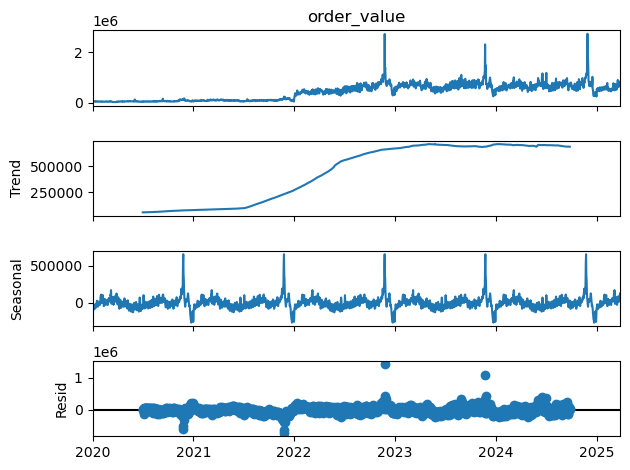

In [9]:
result = seasonal_decompose(sales['order_value'], model='additive', period=365)
result.plot()
plt.show()

I used __*decomposition*__ to break the sales data into its three main parts: Trend, Seasonal, and Residual. This plot clearly shows what drives the sales.

1. __Original Data__ (order_value): This is the raw sales line, showing all the changes together.

2. __Trend__: This shows the long-term movement of sales. The trend was *flat* in 2020/2021, then grew strongly until early 2023, and has stayed *high* since then. This confirms the major growth we noted.

3. __Seasonal__: This shows the regular, repeating patterns that happen every year. We see large, regular *spikes* that repeat yearly. These are the end-of-year busy seasons (like November/December) we saw in the heatmap.

4. __Residual (Noise)__: This is what is left over after taking out the Trend and Seasonal parts. It's the *unpredictable, random daily changes*. Most of the dots are near the zero line, but there are some big dots (outliers), especially after 2022. This tells us that even after taking out the trend and seasonality, there are still a few very big, unexplained sales days.

## ML

### Prophet Forecast

02:59:26 - cmdstanpy - INFO - Chain [1] start processing
02:59:27 - cmdstanpy - INFO - Chain [1] done processing


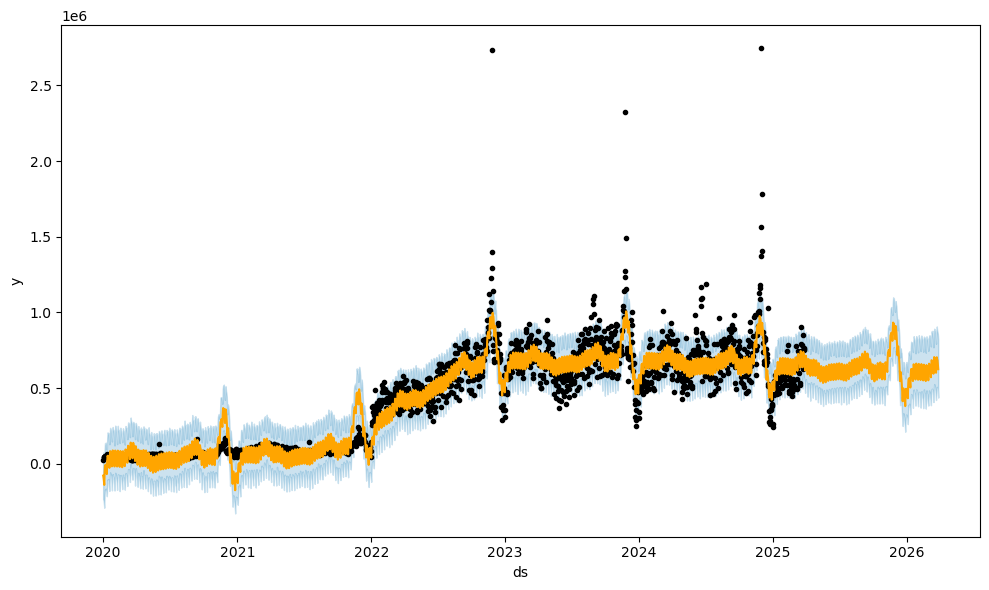

In [10]:
# Prepare data
df = sales.reset_index().rename(columns={"date":"ds", "order_value":"y"})

# Fit model
m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

# Future 365 days
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Plot Prophet forecast
fig = m.plot(forecast)

# Access the axes
ax = fig.gca()

lines = ax.get_lines()
# lines[1] is the predicted yhat
lines[1].set_color('orange')
plt.grid()
plt.show()

I prepared the data and used the __*Prophet model*__. I trained it on the historical data (black dots) and made a 365-day prediction for the next year (2025–2026). 

__How to read__:
- Black Dots: These are the real historical sales from 2020 to early 2025.

- <font color="orange">Orange</font> Line: This is Prophet’s best prediction (the central forecast).

- <font color="blue">Light Blue</font> Area: This is the uncertainty interval. It means the sales are likely to fall somewhere in this range. The wider this area is, the less certain the model is.

What __*Prophet*__ shows us:
- __Trend Captured__: Prophet correctly shows the strong growth trend starting around 2022. The orange forecast line stays at a higher level, matching the recent sales average.

- __Seasonal Cycles Predicted:__ The forecast clearly shows the yearly seasonal pattern continuing into the next year (2025-2026). We can see the predicted sales going up sharply (the yearly spike) and then falling back down.

- __High Uncertainty:__ The light blue area is very wide in the prediction period (2025–2026). This is because the historical data has many high spikes (outliers). Prophet captured the trend and average seasonality, but it has to predict a wide range to be sure it catches the next year's high spikes.

- __Overall Look:__ The forecast is realistic. It shows the client that sales will continue at the high level seen in 2023–2024, but that the exact daily sales will be highly variable.

This forecast gives the client a general idea for their yearly purchasing plan.

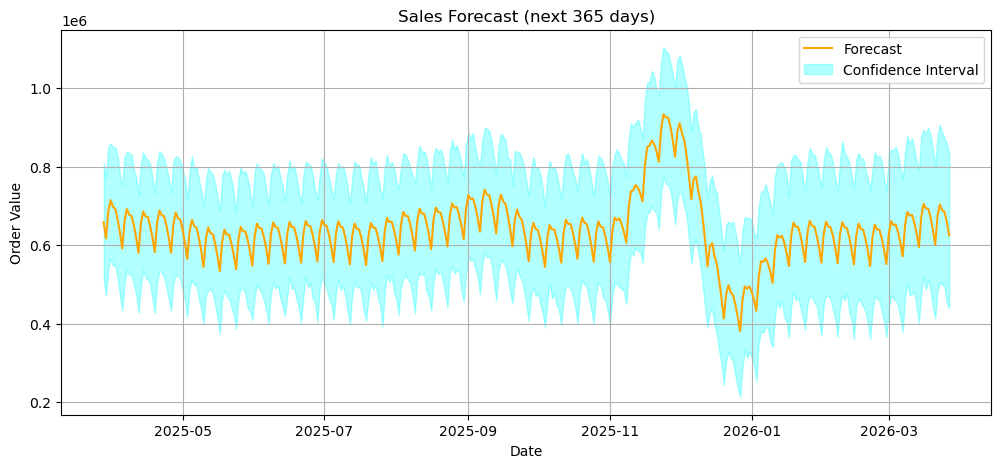

In [11]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

forecast_future = forecast[forecast['ds'] > df['ds'].max()]

plt.figure(figsize=(12,5))
plt.plot(forecast_future['ds'], forecast_future['yhat'], color='orange', label='Forecast')
plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='cyan',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title("Sales Forecast (next 365 days)")
plt.xlabel("Date")
plt.ylabel("Order Value")
plt.legend()
plt.grid()
plt.show()

This __graph__ takes the full __*Prophet*__ forecast and zooms in only on the next 365 days.

- __The <font color="orange">Orange</font> Line (Forecast)__: This is the most likely daily sales number.

- __The <font color="cyan">Blue</font> Area (Uncertainty)__: This shows the range where the sales will probably fall. The client should use the lower limit of this area to make sure they don't order too much *(reducing risk)* and the upper limit to know the most they might need *(preparing for the best sales)*.

In [12]:
forecast_to_excel = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(365).rename(
    columns={
        'ds': 'Data',
        'yhat': 'Expected value',
        'yhat_lower': 'Expected minimum',
        'yhat_upper': 'Expected maximum'})


future_forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(365)
future_forecast['month'] = future_forecast['ds'].dt.to_period('M')

monthly_forecast = future_forecast.groupby('month').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'  }).reset_index().rename(
    columns={
        'month': 'Data',
        'yhat': 'Expected value',
        'yhat_lower': 'Expected minimum',
        'yhat_upper': 'Expected maximum'})

monthly_forecast.loc[len(monthly_forecast)] = [
    'Total',
    monthly_forecast['Expected value'].sum(),
    monthly_forecast['Expected minimum'].sum(),
    monthly_forecast['Expected maximum'].sum()
]

with pd.ExcelWriter("sales_forecast_prophet.xlsx", engine='openpyxl') as writer:
    forecast_to_excel.to_excel(writer, sheet_name='Daily Forecast', index=False)
    monthly_forecast.to_excel(writer, sheet_name='Monthly Forecast', index=False)

After creating the forecast with the Prophet model, the last step is to give the results to the client in a __simple, ready-to-use file__. I saved the full 365-day prediction into an __Excel file__ *sales_forecast.xlsx*.

>It contains:
1. *Daily data*
    - Daily value

    - Daily Expected value

    - Daily Expected minimum

    - Daily Expected maximum
    
     
     
2. *Monthly data*
    - Monthly value

    - Monthly Expected value

    - Monthly Expected minimum

    - Monthly Expected maximum
    
    

3. *Total value of 365 days*

C:\Users\dima\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


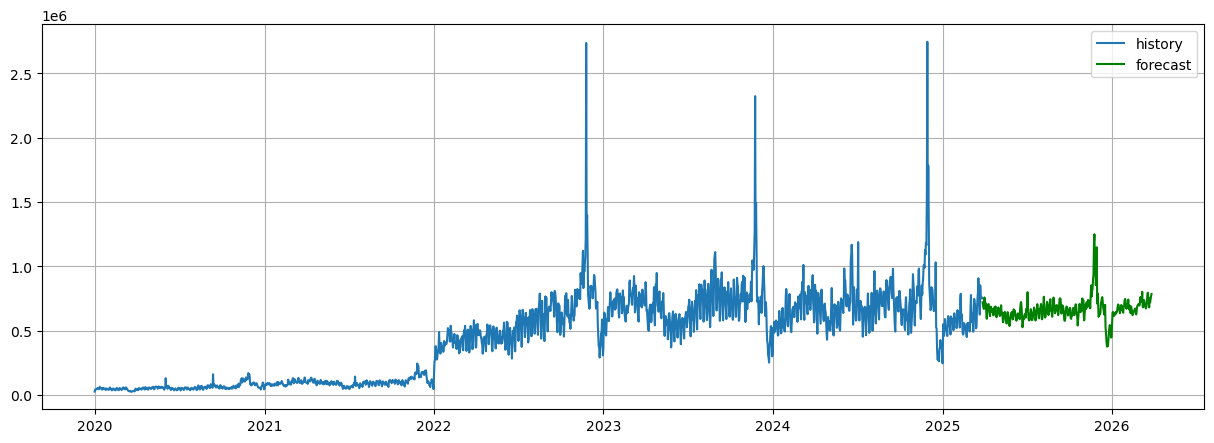

In [13]:
# Ensure daily frequency
sales = sales.asfreq('D').fillna(0)

# Fit model with manual smoothing parameters
model = ExponentialSmoothing(
    sales['order_value'], 
    seasonal='add', 
    seasonal_periods=365
)

fit = model.fit(
    smoothing_level=0.3, 
    smoothing_trend=0.1, 
    smoothing_seasonal=0.2
)

# Forecast
forecast_HW = fit.forecast(365)

# Plot
plt.figure(figsize=(15,5))
plt.plot(sales['order_value'], label="history")
plt.plot(forecast_HW, label="forecast", color='green')
plt.legend()
plt.grid(True)
plt.show()

I used the __Exponential Smoothing Holt-Winters__  model, which is a classic method that predicts sales by smoothly following the past trend and seasonal patterns.

__Model Setup__:
- I made sure the sales data was *daily*.

- I set the model to be *additive* (seasonal='add') because the seasonal spikes seem to stay roughly the same size over time, rather than growing with the sales.

- The *seasonal_periods* was set to 365 to capture the full yearly cycle.

- I used specific values for the *smoothing* parameters to control how fast the model learns from the level (0.3), trend (0.1), and seasonality (0.2).

__What we see__:
- *Good Seasonal Capture*: The <font color="green">green</font> line clearly captures the yearly seasonal pattern—it goes up and down regularly.

- *Less Flexible Trend*: The forecast doesn't predict the sales to grow as strongly as the Prophet model did. The green line stays mostly flat, following the average level of the last year (2024). This is because ETS models can be less flexible than Prophet when dealing with the kind of big, sharp trend change we saw back in 2022.

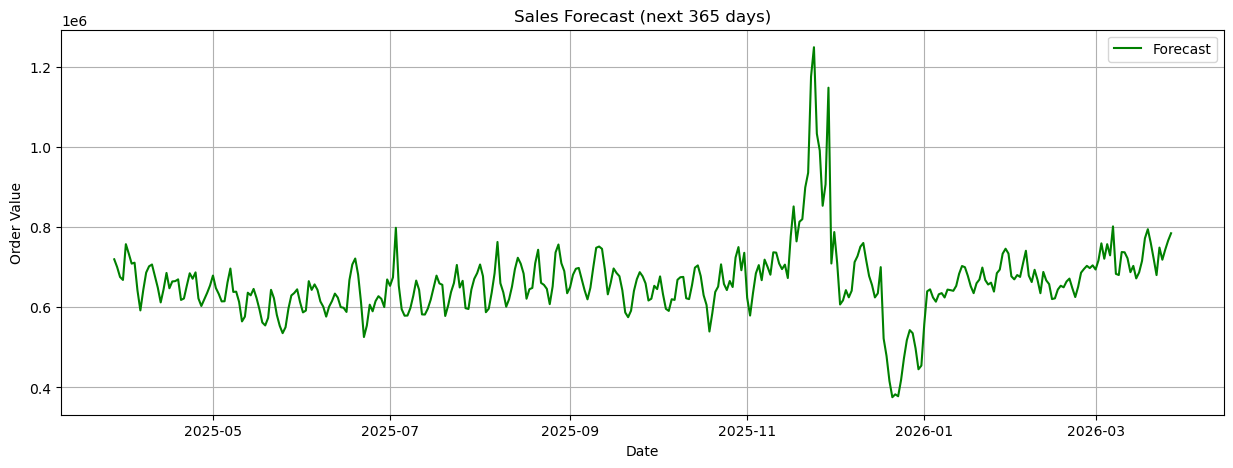

In [14]:
forecast = fit.forecast(365)

plt.figure(figsize=(15,5))
plt.plot(forecast.index, forecast.values, color='green', label="Forecast")
plt.title("Sales Forecast (next 365 days)")
plt.xlabel("Date")
plt.ylabel("Order Value")
plt.legend()
plt.grid(True)
plt.show()

This __graph__ isolates the *Exponential Smoothing* forecast for the next 365 days

__What This Forecast Shows__:
- *Yearly Seasonal Cycle*: The green line clearly shows the sales cycle repeating. Sales are predicted to be stable through summer and autumn, then quickly peak in late November/early December 2025, reaching over 1.2 million.

- *Post-Holiday Drop*: The sales are predicted to drop sharply right after the peak, reaching the lowest point (around 400,000) in January 2026.

- *Weekly Fluctuations*: We can still see the small, regular waves in the line throughout the year. This means the model has captured the fact that sales are higher on certain days of the week. This means that we can rely more on this model when talking about a specific day, rather than a period.

- *Model Difference*: Compared to the Prophet model, the ETS model predicts an even higher seasonal peak (over 1.2M vs Prophet's 950K). However, the base level of the ETS forecast looks less optimistic than Prophet's average line.

In [15]:
# Generate future dates for the next 365 days
future_dates = pd.date_range(start=sales.index[-1] + pd.Timedelta(days=1), periods=365)

# Create a DataFrame for daily forecast
daily_forecast_HW = pd.DataFrame({
    'Data': future_dates,
    'Expected value': forecast_HW.values
})

# Monthly forecast: sum of daily predictions per month
daily_forecast_HW['month'] = daily_forecast_HW['Data'].dt.to_period('M')
monthly_forecast_HW = daily_forecast_HW.groupby('month')['Expected value'].sum().reset_index()
monthly_forecast_HW.rename(columns={'month':'Data'}, inplace=True)

# Calculate total expected value for next 365 days
total_expected = daily_forecast_HW['Expected value'].sum()

# Add a summary row to Monthly Forecast
monthly_forecast_HW.loc[len(monthly_forecast_HW)] = ['Total', total_expected]

# Export to Excel
with pd.ExcelWriter("holtwinters_forecast.xlsx", engine='openpyxl') as writer:
    daily_forecast_HW[['Data','Expected value']].to_excel(writer, sheet_name='Daily Forecast', index=False)
    monthly_forecast_HW.to_excel(writer, sheet_name='Monthly Forecast', index=False)

For Exponential Smoothing model I also created Excel file.

>It contains:
1. *Daily data*
    
2. *Monthly data*
 
3. *Total value of 365 days*

### Conclusion

The *goal* of this project was to __predict daily sales for the next 365 days__ to help the client with purchasing goods. We used five years of historical data and tested two models: __Prophet__ and __Exponential Smoothing (ETS)__.

__Key Findings from the Data__:

- *Strong Growth*: Sales have grown a lot since the start of 2022. The forecast must continue this higher level.

- *Clear Seasonality*: Every year, there is a large spike in sales in the late months, especially November and December.

- *High Volatility*: The daily sales jump around a lot, meaning the client needs to plan for a wide range of possible sales numbers.

__Model Comparison and Final Choice__:
- __Prophet__:
    1. __Strength.__ Great at handling the changing growth trend and providing a wide, realistic uncertainty range (Expected Min/Max).
    2. __Problem.__ The wide range makes the exact daily prediction harder to trust.
    3. __Best choice__ for general purchasing and managing risk.
- __Exponential Smoothing (Holt-Winters)__:
    1. __Strength.__ Gives a clear, strong forecast for the seasonal cycle and peak value.
    2. __Problem.__ Does not capture the strong, long-term growth trend as well as Prophet.
    3. Good as a __second opinion__ to confirm the timing of the seasonal spike.

__In summary:__ The __Prophet__ forecast is better for *Strategic Purchasing* and *Risk Management*, while the __ETS__ forecast is best for Confirming the *Seasonal* Cycle Timing.